In [1]:
import matplotlib
import data_collector as dc
import pandas as pd
import pathlib
import urllib.request
import geopandas as gpd
import ipywidgets as widgets
import folium
import importlib

In [2]:
import geo_information as geo
import data_processing as dproc
importlib.reload(geo)
geo_information = geo.GeoInformation()

In [3]:
importlib.reload(dproc)
dp = dproc.Data_Processor()
dp._create_tables()
dp._populate_pc_data_table()
dp.standardize_data()
dp.run_PCA()

In [4]:
selected_state = widgets.Dropdown(options=sorted(geo_information.get_states()))

In [8]:
selected_state

Dropdown(index=5, options=('Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut'…

In [9]:
geo_information.set_active_state(selected_state.value)
state_metros = geo_information.get_state_metros(selected_state.value)
selected_metro = widgets.Dropdown(options = state_metros)

In [11]:
selected_metro

Dropdown(index=5, options=('Boulder, CO', 'Breckenridge, CO', 'Cañon City, CO', 'Colorado Springs, CO', 'Craig…

In [12]:
geo_information.set_active_metro(selected_metro.value)

In [13]:
# initialize plot stuff & save geojson file
plt_data = geo_information.set_plot_data()
plt_data.to_file('metro_area.json',driver = 'GeoJSON')

In [14]:
puma_map = folium.Map(location = geo_information.get_active_city_location(), zoom_start = 6)
folium.Choropleth(geo_data='metro_area.json',
                  data = dp.pc_DF,
                  columns = ['GEO.id2','PC1'],
                  key_on='properties.GEOID10',
                  fill_color='GnBu',
                  fill_opacity=0.8,
                  line_opacity=0.4,
                  legenend_name='test',
                  name='choropleth').add_to(puma_map)

In [15]:
puma_map

### Validation

Next, we consider two ideas for validating the model (i) modeling effectivess and (ii) an analysis of the individual principle components.

In [16]:
dp.pca.explained_variance_ratio_

array([0.38082889, 0.0843576 , 0.05479052])

In [17]:
new_dataframe_train = pd.DataFrame(columns=['pc1','pc2','pc3','gdp'])
new_dataframe_test = pd.DataFrame(columns=['pc1','pc2','pc3','gdp'])
train_idx = range(0,300)

In [18]:
for index, row in dp.metro_gdp_df.iterrows():
    city, state_abb, city_state_abb = dp._get_city_state(row['GeoName'])
    state = dp.state_abb_df[dp.state_abb_df['Abbrev']==state_abb]['State'].iloc[0].strip(' ')
        
    geo_information.set_active_state(state)
    geo_information.set_active_metro(city_state_abb)
    metro = geo_information.get_active_metro()
    geo_information.get_metro_counties(metro)
    get_geo_ids = geo_information.set_plot_data()['GEOID10']
        
    geo_id_mask = dp.pc_DF['GEO.id2'].isin(get_geo_ids.array)
    
    row_data = (dp.pc_DF[geo_id_mask][['PC1']].mean()[0],
                dp.pc_DF[geo_id_mask][['PC2']].mean()[0],
                dp.pc_DF[geo_id_mask][['PC3']].mean()[0],
                row['percent_chg'])
    if index in train_idx:
        new_dataframe_train.loc[metro] = row_data
    else:
        new_dataframe_test.loc[metro] = row_data

In [19]:
from sklearn import linear_model
import numpy as np

regr = linear_model.LinearRegression()
regr.fit(new_dataframe_train[['pc1','pc2','pc3']].fillna('0'),new_dataframe_train['gdp'])
regr_pc1 = linear_model.LinearRegression()
regr_pc1.fit(new_dataframe_train[['pc1']].fillna('0'),new_dataframe_train['gdp'])
regr_pc2 = linear_model.LinearRegression()
regr_pc2.fit(new_dataframe_train[['pc2']].fillna('0'),new_dataframe_train['gdp'])
regr_pc3 = linear_model.LinearRegression()
regr_pc3.fit(new_dataframe_train[['pc3']].fillna('0'),new_dataframe_train['gdp'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

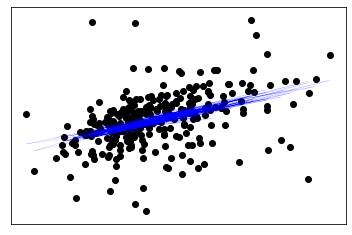

In [21]:
import matplotlib.pyplot as plt

plt.scatter(new_dataframe_train['pc1'], new_dataframe_train['gdp'],  color='black')
plt.plot(new_dataframe_train['pc1'], regr.predict(new_dataframe_train[['pc1','pc2','pc3']].fillna('0')), color='blue', linewidth=0.1)
plt.xticks(())
plt.yticks(())
plt.show()

In [22]:
regr.coef_

array([0.02218459, 0.01010313, 0.01078066])

In [23]:
regr.score(new_dataframe_test[['pc1','pc2','pc3']].fillna('0') ,new_dataframe_test['gdp'])

0.292576106728182

In [24]:
regr_pc1.score(new_dataframe_test[['pc1']].fillna('0'), new_dataframe_test['gdp'])

0.27378637527129634

In [25]:
regr_pc2.score(new_dataframe_test[['pc2']].fillna('0'), new_dataframe_test['gdp'])

0.0159044039363041

In [26]:
regr_pc3.score(new_dataframe_test[['pc3']].fillna('0'), new_dataframe_test['gdp'])

0.020851740907603333

### Analysis of individual components

In [27]:
list(dp.pca.components_)[0]

array([ 0.2515821 ,  0.22392324,  0.28586226,  0.26798493,  0.17528753,
        0.19897773,  0.1187301 ,  0.19160882,  0.08354625,  0.10386274,
        0.30059674,  0.27918808,  0.31050749,  0.09381538,  0.22226886,
        0.13920454,  0.03989132,  0.28826161,  0.30420727, -0.05989646,
        0.10905546,  0.10095496,  0.15281895,  0.15864064, -0.02030842])

Biggest elements (> 0.25) - vehicles avaliable, owner occupied housing units, family households, population
total housing units, employement status
Negative values (< 0) - income and benefits (?), percent of families whose incomes are below poverty level

In [28]:
list(dp.pca.components_)[1]

array([ 0.17856542, -0.3962039 ,  0.06988273,  0.19039472, -0.22327573,
        0.10801425, -0.09279608,  0.15368553, -0.01914791, -0.12940165,
        0.02174304, -0.03335149, -0.06465928, -0.29210695, -0.38842085,
        0.29719581, -0.05856907,  0.08961187, -0.00665807, -0.34866629,
        0.01370103,  0.08500316,  0.14017864,  0.10394014,  0.39738359])

Largest Magnitude (> 0.35) - renter occupided housing (-), occupied units paying rent (-), percentage of families whose incomes are below poverty level (-), income and benefits (+)

In [29]:
list(dp.pca.components_)[2]

array([ 0.02340277,  0.00518295,  0.03293482,  0.01262038, -0.07328197,
       -0.03599946, -0.14853987, -0.13548741,  0.52345562,  0.61957204,
       -0.02911824,  0.01480619, -0.01904034,  0.09018489,  0.0176048 ,
       -0.11745279,  0.08142544, -0.01517761, -0.06587745,  0.03477425,
       -0.20634166,  0.20634634, -0.01120222, -0.09445807,  0.40365571])

Largest Magnitude (> 0.4) - Estimated Residence One Year Ago (Different County / Different State) (+)
                            Estimated Residence One Year Ago (Different house) (+)
                            Income and benefits (+)

### Notable Absences

The education features doe not appear to place a major role